In [1]:
import http.client
import urllib.parse
import json
import locale
import pandas as pd
from datetime import datetime

import requests

In [2]:
ns_ccm_api_key = "e4eafce976694a39bc093bb0ceff8ea1";
ns_planner_api_key = "aaa229133182438683d238956548a1a7"

def api_call(host, base_url, headers, params, expire_time=None):
    data = None
    try:
        url = host + '/' + base_url + "?%s" % params
        conn = http.client.HTTPSConnection(host)
        conn.request("GET", base_url + "?%s" % params, "{body}", headers)
        response = conn.getresponse()
        data = json.loads(response.read())
        conn.close()
        return data
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
    return data

def get_stations():
    url = "/reisinformatie-api/api/v2/stations"
    params = None
    headers_nsapi = {
        'Authorization': '',
        'Ocp-Apim-Subscription-Key': ns_planner_api_key,
    }
    x = api_call("gateway.apiportal.ns.nl", url, headers_nsapi, params)
    return x
    
def get_crowding(journey_id, dt, station):
    url = "/trein/drukte/" + str(journey_id) + "/" + dt;
    headers_nsapi = {
        'Authorization': '',
        'Ocp-Apim-Subscription-Key': ns_ccm_api_key,
    }
    params = urllib.parse.urlencode({'api-version': "1.0"})
    x = api_call("gateway.apiportal.ns.nl", url, headers_nsapi, params)
    try:
        for v in x:
            if v['vertrekstationVerkorting'] == station:
                return v['trein']['classificatie'], v['trein']['reizigers'], v['trein']['materieeltypen']
    except:
        print('Sorry')  
        return -1, ""
    print('Nope')
    return -1, -1, ""

get_crowding("3616", "2022-09-08", "DV")[0]

3

In [3]:
# stations_json = get_stations()
# stations_json
# rows = []
# for station in stations_json['payload']:
#     rows.append([station['namen']['lang'], station['code']])
#     rows.append([station['namen']['middel'], station['code']])
#     rows.append([station['namen']['kort'], station['code']])
# stationslijst = pd.DataFrame(rows, columns=["Stationsnaam", "Stationscode"])
# stationslijst.to_pickle('stationslijst.pcl')

stationslijst = pd.read_pickle('stationslijst.pcl')
stationslijst = stationslijst.drop_duplicates()

stationslijst = stationslijst.append({'Stationsnaam': "Hertogenbosch ('s)", 'Stationscode': 'HT'}, ignore_index=True)
stationslijst = stationslijst.append({'Stationsnaam': "Harde ('t)", 'Stationscode': 'HDE'}, ignore_index=True)

In [4]:
meldingen = pd.read_pickle('rover_meldingen.pcl')

def abs_time_diff(a, b):
    diff = (b - a) if (a < b) else (a - b)
    return diff
    #return (a - b).total_seconds()
    
meldingen['Tijdsverschil'] = meldingen.apply(lambda x: abs_time_diff(x.Tijdstip, x.Scrapetijd), axis=1)
meldingen['Tijdsverschil'] = (pd.Timestamp('now').normalize() + meldingen['Tijdsverschil'] ).dt.time
meldingen['Meldingvoorvertrek'] = meldingen['Scrapetijd'] < meldingen['Tijdstip']
meldingen['Treinserie'] = meldingen['Ritnummer'].div(100).astype(int) * 100
meldingen['Datum'] = pd.to_datetime(meldingen['Tijdstip'].dt.date)

meldingen = meldingen.merge(stationslijst, left_on='Van', right_on='Stationsnaam', how='left').rename(columns={'Stationscode' : 'VanCode'})
meldingen = meldingen.merge(stationslijst, left_on='Naar', right_on='Stationsnaam', how='left').rename(columns={'Stationscode' : 'NaarCode'})

meldingen = meldingen[['Tijdstip', 'Type', 'Ritnummer', 'Van', 'VanCode', 'Naar', 'NaarCode', 'Scrapetijd',
                       'Tijdsverschil', 'Meldingvoorvertrek', 'Treinserie', 'Datum']]
meldingen['Prognose'] = None

meldingen

,Tijdstip,Type,Ritnummer,Van,VanCode,Naar,NaarCode,Scrapetijd,Tijdsverschil,Meldingvoorvertrek,Treinserie,Datum,Prognose
0,2022-09-08 07:39:00,Sprinter,4618,Almere Muziekwijk,ALMM,Amsterdam Muiderpoort,ASDM,2022-09-08 21:10:29,13:31:29,False,4600,2022-09-08,None
1,2022-09-08 07:46:00,Intercity,3616,Deventer,DV,Zwolle,ZL,2022-09-08 20:20:27,12:34:27,False,3600,2022-09-08,None
2,2022-09-08 08:11:00,Intercity,11622,Amersfoort Centraal,AMF,Amsterdam Zuid,ASDZ,2022-09-08 20:30:28,12:19:28,False,11600,2022-09-08,None
3,2022-09-08 08:13:00,Intercity,2418,Den Haag HS,GV,Amsterdam Zuid,ASDZ,2022-09-08 19:28:43,11:15:43,False,2400,2022-09-08,None
4,2022-09-08 11:36:00,Intercity,2241,Den Haag Laan v NOI,LAA,Leiden Centraal,LEDN,2022-09-08 20:10:27,08:34:27,False,2200,2022-09-08,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,2022-10-16 19:50:00,Intercity,670,Zwolle,ZL,Rotterdam Alexander,RTA,2022-10-16 21:25:25,01:35:25,False,600,2022-10-16,None
2490,2022-10-16 20:05:00,Intercity,575,Rotterdam Centraal,RTD,Gouda,GD,2022-10-16 21:25:25,01:20:25,False,500,2022-10-16,None
2491,2022-10-16 20:48:00,Intercity,670,Utrecht Centraal,UT,Rotterdam Alexander,RTA,2022-10-16 21:25:25,00:37:25,False,600,2022-10-16,None
2492,2022-10-16 20:50:00,Intercity,674,Zwolle,ZL,Rotterdam Centraal,RTD,2022-10-16 21:00:24,00:10:24,False,600,2022-10-16,None


In [5]:
meldingen = pd.read_pickle('rover_meldingen_extended.pcl').append(meldingen)
meldingen = meldingen.sort_values(['Tijdstip', 'Type', 'Ritnummer', 'Van', 'Naar', 'Scrapetijd'])
meldingen = meldingen.drop_duplicates(['Tijdstip', 'Type', 'Ritnummer', 'Van', 'Naar'], keep='first'). \
            reset_index(drop=True)

def get_prognose(ritnummer, datum, van, prognose):
    if prognose:
        return prognose
    else:
        print('New')
        return get_crowding(ritnummer,datum, van)[0]
meldingen['Prognose'] = meldingen.apply(lambda x: get_prognose(str(x["Ritnummer"]), str(x["Datum"])[0:10], x["VanCode"], x['Prognose']), axis=1)

meldingen.to_pickle('rover_meldingen_extended.pcl')
meldingen
#meldingen['Prognose'] = meldingen.apply(lambda x: get_crowding(str(x["Ritnummer"]), str(x["Datum"])[0:10], x["VanCode"])[0], axis=1)

,Tijdstip,Type,Ritnummer,Van,VanCode,Naar,NaarCode,Scrapetijd,Tijdsverschil,Meldingvoorvertrek,Treinserie,Datum,Prognose
0,2022-09-08 07:39:00,Sprinter,4618,Almere Muziekwijk,ALMM,Amsterdam Muiderpoort,ASDM,2022-09-08 21:10:29,13:31:29,False,4600,2022-09-08,-1
1,2022-09-08 07:46:00,Intercity,3616,Deventer,DV,Zwolle,ZL,2022-09-08 20:20:27,12:34:27,False,3600,2022-09-08,3
2,2022-09-08 08:11:00,Intercity,11622,Amersfoort Centraal,AMF,Amsterdam Zuid,ASDZ,2022-09-08 20:30:28,12:19:28,False,11600,2022-09-08,3
3,2022-09-08 08:13:00,Intercity,2418,Den Haag HS,GV,Amsterdam Zuid,ASDZ,2022-09-08 19:28:43,11:15:43,False,2400,2022-09-08,3
4,2022-09-08 11:36:00,Intercity,2241,Den Haag Laan v NOI,LAA,Leiden Centraal,LEDN,2022-09-08 20:10:27,08:34:27,False,2200,2022-09-08,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,2022-10-16 19:50:00,Intercity,670,Zwolle,ZL,Rotterdam Alexander,RTA,2022-10-16 21:25:25,01:35:25,False,600,2022-10-16,1
2490,2022-10-16 20:05:00,Intercity,575,Rotterdam Centraal,RTD,Gouda,GD,2022-10-16 21:25:25,01:20:25,False,500,2022-10-16,1
2491,2022-10-16 20:48:00,Intercity,670,Utrecht Centraal,UT,Rotterdam Alexander,RTA,2022-10-16 21:25:25,00:37:25,False,600,2022-10-16,1
2492,2022-10-16 20:50:00,Intercity,674,Zwolle,ZL,Rotterdam Centraal,RTD,2022-10-16 21:00:24,00:10:24,False,600,2022-10-16,1


In [6]:
meldingen[meldingen.Meldingvoorvertrek]

,Tijdstip,Type,Ritnummer,Van,VanCode,Naar,NaarCode,Scrapetijd,Tijdsverschil,Meldingvoorvertrek,Treinserie,Datum,Prognose
27,2022-09-09 17:21:00,Sprinter,6464,Eindhoven Centraal,EHV,Eindhoven Strijp-S,EHS,2022-09-09 12:30:33,04:50:27,True,6400,2022-09-09,1
52,2022-09-10 18:47:00,Intercity,670,Leeuwarden,LW,Amersfoort Centraal,AMF,2022-09-10 14:00:27,04:46:33,True,600,2022-09-10,1
53,2022-09-10 20:28:00,Intercity,670,Amersfoort Centraal,AMF,Utrecht Centraal,UT,2022-09-10 15:20:27,05:07:33,True,600,2022-09-10,2
61,2022-09-11 10:20:00,Intercity,532,Zwolle,ZL,Amersfoort Centraal,AMF,2022-09-11 09:20:36,00:59:24,True,500,2022-09-11,3
114,2022-09-12 12:12:00,Intercity,3747,Schiphol Airport,SHL,Rotterdam Centraal,RTD,2022-09-12 11:40:33,00:31:27,True,3700,2022-09-12,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2410,2022-10-14 17:22:00,Intercity,11761,Amersfoort Centraal,AMF,Apeldoorn,APD,2022-10-14 10:25:27,06:56:33,True,11700,2022-10-14,1
2415,2022-10-14 18:54:00,Intercity,3069,Amsterdam Centraal,ASD,Utrecht Centraal,UT,2022-10-14 07:15:35,11:38:25,True,3000,2022-10-14,2
2418,2022-10-14 21:26:00,Intercity,1872,Schiphol Airport,SHL,Leiden Centraal,LEDN,2022-10-14 13:10:25,08:15:35,True,1800,2022-10-14,1
2452,2022-10-15 21:49:00,Intercity,579,Utrecht Centraal,UT,Amersfoort Centraal,AMF,2022-10-15 21:45:28,00:03:32,True,500,2022-10-15,2


In [7]:
len(meldingen[meldingen['Scrapetijd'] < meldingen['Tijdstip']]) / len(meldingen)

0.13191659983961507

In [8]:
meldingen[['Ritnummer', 'Tijdstip']].groupby('Ritnummer').count().sort_values('Tijdstip',ascending=False).head(5)

,Tijdstip
Ritnummer,
622,44
520,35
559,33
1827,32
11720,22


<AxesSubplot:xlabel='Tijdstip'>

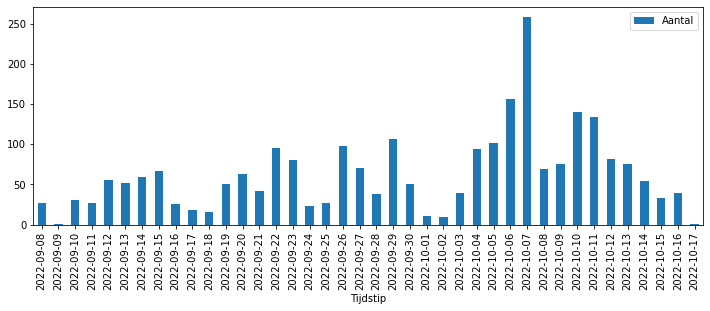

In [9]:
meldingen[['Ritnummer']].groupby(meldingen['Tijdstip'].dt.date).count().reset_index().sort_values('Tijdstip'). \
    rename(columns={'Ritnummer': 'Aantal'}).plot.bar(x='Tijdstip', figsize=(12,4))

<AxesSubplot:xlabel='Tijdstip'>

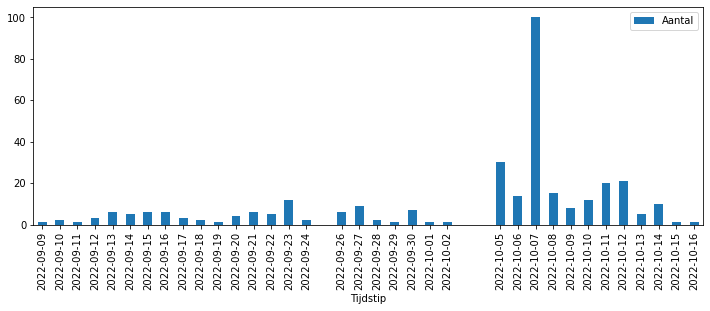

In [20]:
meldingen[meldingen['Meldingvoorvertrek']][['Ritnummer']].groupby(meldingen['Tijdstip'].dt.date).count().reset_index().sort_values('Tijdstip'). \
    rename(columns={'Ritnummer': 'Aantal'}).plot.bar(x='Tijdstip', figsize=(12,4))

In [10]:
hm = meldingen[['Datum', 'Treinserie', 'Ritnummer']].groupby(['Datum','Treinserie']).count().reset_index(). \
     sort_values('Ritnummer', ascending=False).rename(columns={'Ritnummer': 'Aantal'})
hm = hm[hm.Aantal > 3]
hm.head(4)

,Datum,Treinserie,Aantal
544,2022-10-07,500,37
545,2022-10-07,600,33
514,2022-10-06,600,23
559,2022-10-07,3600,19


In [11]:
hm = hm.pivot(index=["Datum"], columns="Treinserie", values="Aantal").reset_index().fillna(0)
hm.iloc[:, 1:] = hm.iloc[:, 1:].astype(int)
hm.style.background_gradient(cmap='YlOrRd')

Treinserie,Datum,500,600,700,800,1100,1600,1700,1800,2000,2200,2400,2800,3000,3100,3500,3600,3700,4000,4600,4800,4900,5000,5100,5600,6100,6400,6600,6900,8100,11700,300700,301800,304600,704600
0,2022-09-08 00:00:00,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-09-10 00:00:00,5,7,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-09-11 00:00:00,9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-09-12 00:00:00,6,4,0,4,0,0,0,0,0,0,0,0,5,0,0,4,0,0,0,6,0,0,0,0,0,0,4,0,0,0,0,0,0,0
4,2022-09-13 00:00:00,4,0,0,0,0,0,0,0,0,0,4,0,5,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2022-09-14 00:00:00,4,4,0,6,0,0,0,0,0,9,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2022-09-15 00:00:00,5,0,0,6,0,0,0,0,0,8,0,0,5,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
7,2022-09-16 00:00:00,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2022-09-17 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
9,2022-09-18 00:00:00,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
meldingen[meldingen.Treinserie == 500][['Ritnummer', 'Van']].groupby('Ritnummer').count(). \
     rename(columns={'Van': 'Aantal'}).sort_values('Aantal', ascending=False).iloc[0:6]

,Aantal
Ritnummer,
520,35
559,33
524,22
563,18
528,18
555,15


In [13]:
meldingen[['Ritnummer', 'Naar']].groupby('Naar').count(). \
         rename(columns={'Ritnummer':'Aantal'}).sort_values('Aantal', ascending=False).iloc[0:10]

,Aantal
Naar,
Utrecht Centraal,429
Zwolle,214
Amersfoort Centraal,193
Leiden Centraal,140
Den Haag Centraal,121
Amsterdam Centraal,107
Rotterdam Centraal,104
Hertogenbosch ('s),102
Amsterdam Zuid,79


In [14]:
meldingen[meldingen.Meldingvoorvertrek][['Ritnummer', 'Naar']].groupby('Naar').count(). \
         rename(columns={'Ritnummer':'Aantal'}).sort_values('Aantal', ascending=False).iloc[0:10]

,Aantal
Naar,
Utrecht Centraal,49
Zwolle,28
Rotterdam Centraal,19
Den Haag Centraal,19
Leiden Centraal,15
Amersfoort Centraal,15
Hertogenbosch ('s),11
Gouda,10
Apeldoorn,9


In [15]:
meldingen[['Scrapetijd', 'Van']].groupby('Scrapetijd').count().reset_index().sort_values('Van', ascending=False).iloc[0:8]

,Scrapetijd,Van
126,2022-09-14 08:30:36,10
145,2022-09-14 19:00:28,10
276,2022-09-20 09:00:32,10
320,2022-09-22 08:10:35,10
439,2022-09-26 07:30:33,10
445,2022-09-26 09:00:25,10
833,2022-10-07 08:20:30,10
835,2022-10-07 08:40:31,9


In [16]:
# meldingen[(meldingen.Treinserie == 500) & (meldingen.Datum == '2022-10-07')].sort_values('Scrapetijd')

In [17]:
meldingen[~meldingen.Meldingvoorvertrek][['Prognose', 'Type']].groupby('Prognose').count().rename(columns={'Type': 'Aantal'})

,Aantal
Prognose,
-1,95
1,490
2,650
3,930


In [18]:
meldingen[meldingen.Meldingvoorvertrek][['Prognose', 'Type']].groupby('Prognose').count().rename(columns={'Type': 'Aantal'})

,Aantal
Prognose,
-1,16
1,92
2,113
3,108


In [1]:
import utils
import logging

import locale
import pandas as pd
from datetime import datetime
import requests

CONFIG_FILE = 'systems.cred'


def run(config=None):
    logger = logging.getLogger('home automation')
    if config is None:
        config = utils.get_config(CONFIG_FILE)
        logging.basicConfig(filename="script.log", level=logging.DEBUG)
        ch = logging.StreamHandler()
        ch.setFormatter(logging.Formatter('%(asctime)s - {%(filename)21s:%(lineno)3d} - %(levelname)5s - %(message)s'))
        logger.addHandler(ch)

    logger.debug("Script: Volle treinen parser")

    if datetime.now().minute in [0, 10, 20, 30, 40, 50]:
        content = requests.get('https://volletreinen.nl/statistieken').text
        content = content[content.index("Laatste 10 meldingen"):]
        content = content[content.index("<table class"):]
        content = content[:content.index("/table>") + 7]

        meldingen = pd.read_html(content)[0]
        meldingen.columns = ['Datum', 'Trein', 'Vertrektijd', 'Gemeld traject']
        meldingen = meldingen[~(meldingen.Datum == 'Datum')]

        meldingen['Scrapetijd'] = datetime.now()
        meldingen['Scrapetijd'] = meldingen['Scrapetijd'].astype('datetime64[s]')

        locale.setlocale(locale.LC_ALL, 'nl_NL.UTF-8')

        meldingen['Tijdstip'] = meldingen['Datum'] + ' ' + meldingen['Vertrektijd']
        meldingen['Tijdstip'] = pd.to_datetime(meldingen['Tijdstip'], format="%A %d %B %Y %H:%M")

        meldingen = meldingen[meldingen.Trein.str.contains('NS')].copy()

        splitted = meldingen['Gemeld traject'].str.split('»', expand=True)
        meldingen['Van'] = splitted[0].str.strip()
        meldingen['Naar'] = splitted[1].str.strip()

        splitted = meldingen['Trein'].str.split(' ', expand=True)
        meldingen['Type'] = splitted[1].str.strip()
        meldingen['Ritnummer'] = splitted[2].str.strip().astype(int)

        meldingen = meldingen[['Tijdstip', 'Type', 'Ritnummer', 'Van', 'Naar', 'Scrapetijd']]

        try:
            stored_meldingen = pd.read_pickle('rover_meldingen.pcl')
            org_count = len(stored_meldingen)
            logger.info("Bestaand aantal medlingen : " + str(org_count))
            meldingen = stored_meldingen.append(meldingen)
        except:
            meldingen = meldingen

        meldingen = meldingen.sort_values(['Tijdstip', 'Type', 'Ritnummer', 'Van', 'Naar', 'Scrapetijd'])
        meldingen = meldingen.drop_duplicates(['Tijdstip', 'Type', 'Ritnummer', 'Van', 'Naar'], keep='first'). \
            reset_index(drop=True)
        meldingen.to_pickle('rover_meldingen.pcl')
        logger.info("Nieuw aantal meldingen    : " + str(len(meldingen) - org_count))
        logger.info("DONE volle treinen")

if __name__ == '__main__':
    run()

ModuleNotFoundError: No module named 'utils'